In [304]:
#  For project clustering steps:
# 1- Load the Pandas data frame songs of the audio features (at least 1000 songs as different as possible).🎹 ----DONE
# 2- Standardize the data using Standardscaler ----DONE
# 3- Save the scaler for future use on the new user input song, using Pickle. (tomorrow)
# 4- Select the number of clusters k.
# 5- Adjust k means cluster.
# 6- Build the elbow graph to find the best k. (tomorrow)
# 7- Use the model with the best k to assign each observation in your data frame to its cluster number using model.predict (add cluster columns to the pandas data frame).
# 8- Save the model with the best k as your final model using pickle. (tomorrow)

# 📍 For the final product tasks and the full scenario:
# 1- Get the song name from the user as input ---------- DONE
# 2- Play the input song in the music embed player. ---------- DONE
# 3- Get the audio features for this song from the Spotify API using sp.audio_features(trackid). Be careful to keep only the audio features columns.---------- DONE
# 4- Load the StandardScaler using Pickle and use it to scale the REQUESTED_SONG.(tomorrow)
# 5- Use kmeans_model.predict(new scaled audio dataset for the REQUESTED_SONG) to predict the cluster (label) for the REQUESTED_SONG.
# 6- Return a random song from the same cluster that the REQUESTED_SONG belongs to from your data frame and suggest it to the user.
# 7- Play it using the built-in music player.
# 8*- Try to Streamlit? ☀️ (optional) 

In [305]:
from stackapi import StackAPI
from bs4 import BeautifulSoup
import requests as re

import pandas as pd
import numpy as np

from random import randint    
from datetime import datetime, timedelta
from time import sleep

import json
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pprint

client_id = os.environ.get("SPOTIPY_CLIENT_ID")
client_secret = os.environ.get("SPOTIPY_CLIENT_SECRET")

sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

from plotly import express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

## Creating the JSON

In [307]:
results = sp.search(q= x, limit=1, market="FR")

json_results = json.dumps(results, ensure_ascii=True)
print(json_results)

{"tracks": {"href": "https://api.spotify.com/v1/search?query=Hello+Adele&type=track&market=FR&offset=0&limit=1", "items": [{"album": {"album_type": "album", "artists": [{"external_urls": {"spotify": "https://open.spotify.com/artist/4dpARuHxo51G3z768sgnrY"}, "href": "https://api.spotify.com/v1/artists/4dpARuHxo51G3z768sgnrY", "id": "4dpARuHxo51G3z768sgnrY", "name": "Adele", "type": "artist", "uri": "spotify:artist:4dpARuHxo51G3z768sgnrY"}], "external_urls": {"spotify": "https://open.spotify.com/album/6TVfiWmo8KtflUAmkK9gGF"}, "href": "https://api.spotify.com/v1/albums/6TVfiWmo8KtflUAmkK9gGF", "id": "6TVfiWmo8KtflUAmkK9gGF", "images": [{"height": 640, "url": "https://i.scdn.co/image/ab67616d0000b2737b9888dc365b8f957c63df14", "width": 640}, {"height": 300, "url": "https://i.scdn.co/image/ab67616d00001e027b9888dc365b8f957c63df14", "width": 300}, {"height": 64, "url": "https://i.scdn.co/image/ab67616d000048517b9888dc365b8f957c63df14", "width": 64}], "is_playable": true, "name": "25", "relea

In [308]:
results['tracks']["items"][0].keys() # All the dictionary
pprint.pprint(results['tracks']['items'][0])

results['tracks']['items'][0]['id'] # Getting song ID

for item in results['tracks']['items']:
    print("The name of song is: '{}' and the id is: {}".format(item['name'],item["id"]))

{'album': {'album_type': 'album',
           'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4dpARuHxo51G3z768sgnrY'},
                        'href': 'https://api.spotify.com/v1/artists/4dpARuHxo51G3z768sgnrY',
                        'id': '4dpARuHxo51G3z768sgnrY',
                        'name': 'Adele',
                        'type': 'artist',
                        'uri': 'spotify:artist:4dpARuHxo51G3z768sgnrY'}],
           'external_urls': {'spotify': 'https://open.spotify.com/album/6TVfiWmo8KtflUAmkK9gGF'},
           'href': 'https://api.spotify.com/v1/albums/6TVfiWmo8KtflUAmkK9gGF',
           'id': '6TVfiWmo8KtflUAmkK9gGF',
           'images': [{'height': 640,
                       'url': 'https://i.scdn.co/image/ab67616d0000b2737b9888dc365b8f957c63df14',
                       'width': 640},
                      {'height': 300,
                       'url': 'https://i.scdn.co/image/ab67616d00001e027b9888dc365b8f957c63df14',
                  

## Understanding the JSON

In [309]:
print("The json file has the following keys: ", list(results.keys())) # We can see that we only have tracks
print("The 'tracks' key has the following child keys: ", list(results["tracks"].keys())) # Let's check the values
print("The query we made is: ", results["tracks"]["href"]) # Query we have searched 
print("The song's info is contained in: ", results["tracks"]["items"]) # items (actual tracks)
print("The limit of the query we've made is: ", results["tracks"]["limit"]) # Limit we have chosen
print("The next page if any: ", results["tracks"]["next"]) # Link to the next page (next 50 tracks)
print("The starting webpage: ", results["tracks"]["offset"]) # Actual offset (starting point)
print("Starting webpage: ", results["tracks"]["previous"]) # Previous search
print("Total number of results: ", results["tracks"]["total"]) # Number of matches

The json file has the following keys:  ['tracks']
The 'tracks' key has the following child keys:  ['href', 'items', 'limit', 'next', 'offset', 'previous', 'total']
The query we made is:  https://api.spotify.com/v1/search?query=Hello+Adele&type=track&market=FR&offset=0&limit=1
The song's info is contained in:  [{'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/4dpARuHxo51G3z768sgnrY'}, 'href': 'https://api.spotify.com/v1/artists/4dpARuHxo51G3z768sgnrY', 'id': '4dpARuHxo51G3z768sgnrY', 'name': 'Adele', 'type': 'artist', 'uri': 'spotify:artist:4dpARuHxo51G3z768sgnrY'}], 'external_urls': {'spotify': 'https://open.spotify.com/album/6TVfiWmo8KtflUAmkK9gGF'}, 'href': 'https://api.spotify.com/v1/albums/6TVfiWmo8KtflUAmkK9gGF', 'id': '6TVfiWmo8KtflUAmkK9gGF', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/ab67616d0000b2737b9888dc365b8f957c63df14', 'width': 640}, {'height': 300, 'url': 'https://i.scdn.co/image/ab67616d00001e0

## Other Infos

In [310]:
print("Track infos")
print(results["tracks"]["items"][0]["artists"]) # Track artists

# print("Track artists")
# print(results["tracks"]["items"][0]["artists"]["0"]["name"]) # Track artists



print("\nTrack ID")
print(results["tracks"]["items"][0]["id"]) # Track ID
print("\nTrack name")
print(results["tracks"]["items"][0]["name"]) # Track name
print("\nPopularity index")
print(results["tracks"]["items"][0]["popularity"]) # Popularity index
print("\nBasically ID")
print(results["tracks"]["items"][0]["uri"]) # Basically ID


Track infos
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/4dpARuHxo51G3z768sgnrY'}, 'href': 'https://api.spotify.com/v1/artists/4dpARuHxo51G3z768sgnrY', 'id': '4dpARuHxo51G3z768sgnrY', 'name': 'Adele', 'type': 'artist', 'uri': 'spotify:artist:4dpARuHxo51G3z768sgnrY'}]

Track ID
1Yk0cQdMLx5RzzFTYwmuld

Track name
Hello

Popularity index
77

Basically ID
spotify:track:1Yk0cQdMLx5RzzFTYwmuld


## Playing the requested Song

In [311]:
from IPython.display import IFrame

track_id = results["tracks"]["items"][0]["id"]
# # track_id= 'spotify:track:3hgl7EQwTutSm6PESsB7gZ'
# IFrame(src="https://open.spotify.com/embed/track/"+track_id+"?utm_source=generator",
#        width="320",
#        height="80",
#        frameborder="0",
#        allowtransparency="true",
#        allow="encrypted-media",
#       )

In [312]:
def play_song(track_id):
    return IFrame(src="https://open.spotify.com/embed/track/"+track_id+"?autoplay=1",
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )

In [313]:
play_song(track_id)

## Track ID of the Song

In [314]:
song_id = results["tracks"]["items"][0]["id"]
song_id

'1Yk0cQdMLx5RzzFTYwmuld'

## Getting the audio features of the Requested Song

In [315]:
print(sp.audio_features(song_id))
sp.audio_features(song_id)

[{'danceability': 0.578, 'energy': 0.43, 'key': 5, 'loudness': -6.134, 'mode': 0, 'speechiness': 0.0305, 'acousticness': 0.33, 'instrumentalness': 0, 'liveness': 0.0854, 'valence': 0.288, 'tempo': 78.991, 'type': 'audio_features', 'id': '1Yk0cQdMLx5RzzFTYwmuld', 'uri': 'spotify:track:1Yk0cQdMLx5RzzFTYwmuld', 'track_href': 'https://api.spotify.com/v1/tracks/1Yk0cQdMLx5RzzFTYwmuld', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1Yk0cQdMLx5RzzFTYwmuld', 'duration_ms': 295502, 'time_signature': 4}]


[{'danceability': 0.578,
  'energy': 0.43,
  'key': 5,
  'loudness': -6.134,
  'mode': 0,
  'speechiness': 0.0305,
  'acousticness': 0.33,
  'instrumentalness': 0,
  'liveness': 0.0854,
  'valence': 0.288,
  'tempo': 78.991,
  'type': 'audio_features',
  'id': '1Yk0cQdMLx5RzzFTYwmuld',
  'uri': 'spotify:track:1Yk0cQdMLx5RzzFTYwmuld',
  'track_href': 'https://api.spotify.com/v1/tracks/1Yk0cQdMLx5RzzFTYwmuld',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1Yk0cQdMLx5RzzFTYwmuld',
  'duration_ms': 295502,
  'time_signature': 4}]

## Extract the Audio Features of the Requested Song in a Dataframe

In [316]:
print(sp.audio_features(results["tracks"]["items"][0]["id"]))

[{'danceability': 0.578, 'energy': 0.43, 'key': 5, 'loudness': -6.134, 'mode': 0, 'speechiness': 0.0305, 'acousticness': 0.33, 'instrumentalness': 0, 'liveness': 0.0854, 'valence': 0.288, 'tempo': 78.991, 'type': 'audio_features', 'id': '1Yk0cQdMLx5RzzFTYwmuld', 'uri': 'spotify:track:1Yk0cQdMLx5RzzFTYwmuld', 'track_href': 'https://api.spotify.com/v1/tracks/1Yk0cQdMLx5RzzFTYwmuld', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1Yk0cQdMLx5RzzFTYwmuld', 'duration_ms': 295502, 'time_signature': 4}]


In [317]:
requested_song_audio_features = pd.DataFrame(sp.audio_features(song_id))
requested_song_audio_features = requested_song_audio_features[["danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness","valence","tempo","id","duration_ms"]]

requested_song_audio_features

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms
0,0.578,0.43,-6.134,0.0305,0.33,0,0.0854,0.288,78.991,1Yk0cQdMLx5RzzFTYwmuld,295502


In [318]:
simple_requested_song_audio_features = requested_song_audio_features[["danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness","valence","tempo","duration_ms"]]

simple_requested_song_audio_features


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.578,0.43,-6.134,0.0305,0.33,0,0.0854,0.288,78.991,295502


## Loading our Songs Database

In [319]:
df = pd.read_csv('Songs_Database.csv', sep=';')
# df.dropna(subset=["id"], inplace=True)
df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms
0,0.531,0.622,-7.751,0.4470,0.60200,0.000000,0.1180,0.5930,167.758,3SgnYOV9ONL0bIHaAcOYE1,454533
1,0.634,0.675,-7.351,0.0926,0.09900,0.000314,0.3620,0.6330,82.183,3IM7zXywZ6sRTtkRjRLxJ8,219866
2,0.826,0.490,-10.477,0.0676,0.00916,0.000004,0.0415,0.6270,74.126,75FYqcxt1YEAtqDLrOeIJn,180267
3,0.525,0.650,-6.961,0.0683,0.08520,0.133000,0.1330,0.7870,175.913,4p4hyqRFdoiw4EMbEsqBdA,289973
4,0.731,0.312,-13.899,0.0816,0.68300,0.879000,0.1040,0.4500,78.001,2Kqb9yoRNsSiHZT26dg2zs,223223
...,...,...,...,...,...,...,...,...,...,...,...
2124,0.851,0.567,-8.074,0.2310,0.21500,0.000000,0.0998,0.4460,119.969,7jbu9k6w67hWlhSinmGT3c,192213
2125,0.875,0.600,-6.818,0.0435,0.01890,0.014300,0.1320,0.0906,119.987,2jTujnt0y344ai1rNOywgr,162638
2126,0.792,0.793,-6.185,0.0841,0.08720,0.000000,0.2200,0.7750,123.031,3w1WjD2zJqjBjDz5fwqQPJ,156578
2127,0.640,0.553,-6.420,0.0411,0.05790,0.000000,0.0914,0.4860,81.992,6GUiIbJ834FcHewby3PwV0,148471


In [320]:
data = df.drop(["id"], axis=1)
data.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.531,0.622,-7.751,0.4470,0.60200,0.000000,0.1180,0.593,167.758,454533
1,0.634,0.675,-7.351,0.0926,0.09900,0.000314,0.3620,0.633,82.183,219866
2,0.826,0.490,-10.477,0.0676,0.00916,0.000004,0.0415,0.627,74.126,180267
3,0.525,0.650,-6.961,0.0683,0.08520,0.133000,0.1330,0.787,175.913,289973
4,0.731,0.312,-13.899,0.0816,0.68300,0.879000,0.1040,0.450,78.001,223223


## Performing Scaling on our Songs_Database

In [321]:
# Create an instance of StandardScaler
scaler = StandardScaler()

# Standardize the data using StandardScaler
X_normalized = scaler.fit_transform(data[["danceability", "energy", "loudness", "speechiness", "instrumentalness","liveness","valence","tempo","duration_ms"]])

# # Print the original data
# print("Original data:")
# print(data.head())

# Create a DataFrame with the normalized data
data_normalized = pd.DataFrame(X_normalized, columns=["danceability", "energy", "loudness", "speechiness", "instrumentalness","liveness","valence","tempo","duration_ms"])

# Perform PCA on the normalized data
pca = PCA(n_components=9)
pca.fit(X_normalized)

# Get the contribution of each principal component to the data variance
# En utilisant pca.explained_variance_ratio_, on peut obtenir une idée de la contribution de chaque composante principale à la variance des données.
# Cela peut aider à décider combien de composantes principales utiliser pour réduire la dimensionnalité ou pour d'autres analyses.
pca.explained_variance_ratio_

# Get the contribution of each principal component to the data variance
explained_variance_ratio = pca.explained_variance_ratio_

# Print the contribution of each principal component
print("Explained variance ratio:")
print(explained_variance_ratio)

# Calculate the cumulative sum of explained variance ratio
# Déterminer combien de composantes principales tu souhaites conserver, en fonction du pourcentage de variance que tu souhaites préserver.
# Par exemple, si la somme cumulative atteint 0,95, cela signifie que les composantes principales retenues capturent 95 % de la variance totale des données.
np.cumsum(pca.explained_variance_ratio_)

# Calculate the cumulative sum of explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Print the cumulative sum of explained variance ratio
print("\nCumulative variance ratio:")
print(cumulative_variance_ratio)

Explained variance ratio:
[0.24212436 0.15373646 0.11444238 0.11119032 0.1037865  0.0924138
 0.08803761 0.07114155 0.02312703]

Cumulative variance ratio:
[0.24212436 0.39586082 0.51030319 0.62149351 0.72528001 0.81769381
 0.90573142 0.97687297 1.        ]


## Save SCALER in file with PICKLE

In [322]:
#Ici, nous ouvrons un fichier nommé "scaler.pkl" en mode d'écriture binaire ('wb'), puis nous utilisons pickle.dump() pour écrire l'objet scaler dans le fichier.
with open('scaler.pkl', 'wb') as fichier:
    pickle.dump(scaler, fichier)

In [323]:
# with open("Songs_Database.csv", "rb") as f: #don't forget the correct path
#      scaler_new = pickle.load(fichier) 

## Finding out the best number of Clusters to use

Training a K-Means model with 5 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 6 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 7 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 8 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 9 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 10 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 11 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 12 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 13 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 14 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 15 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 16 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 17 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 18 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 19 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 20 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 21 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 22 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 23 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 24 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 25 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 26 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 27 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 28 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Training a K-Means model with 29 clusters! 



c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


Text(0.5, 1.0, 'Elbow Method showing the optimal k')

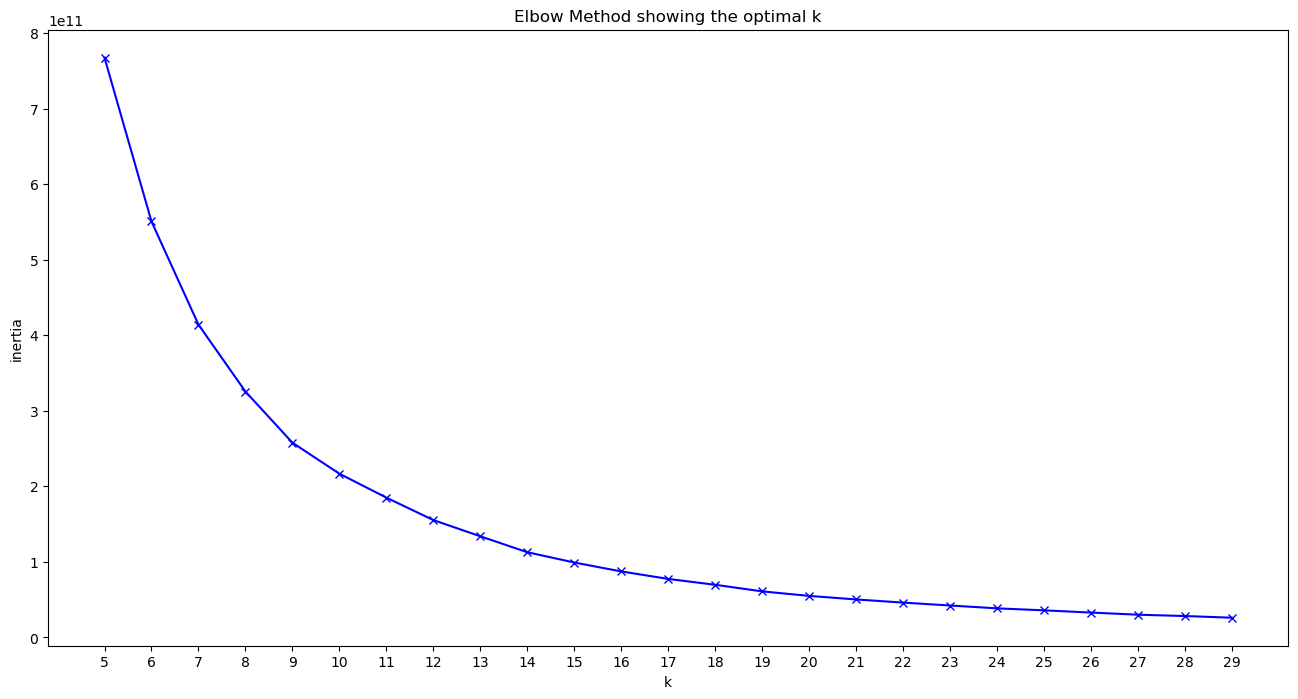

In [324]:
K = range(5, 30) #range of the clusters
inertia = []

for k in K: #for every data in set build a inertia
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0)) #changing the scale
plt.title('Elbow Method showing the optimal k') 

## PCA and KMeans

In [329]:
# Transform the normalized data using the principal components
X_pca = pca.transform(X_normalized)

# Apply K-means clustering to the transformed data
kmeans = KMeans(n_clusters=14, n_init=12)
kmeans.fit(X_pca)
cluster_ids = kmeans.predict(X_pca)
cluster_distances = kmeans.transform(X_pca)

# Print the cluster IDs and distances
print("\nCluster IDs:")
print(cluster_ids)
print("\nCluster distances:")
print(cluster_distances)

c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(



Cluster IDs:
[ 6 12  7 ...  2  7  5]

Cluster distances:
[[5.19485838 6.26825824 5.89966449 ... 6.60456398 5.92461826 5.74181272]
 [2.73595479 3.81935111 2.55160423 ... 2.91868471 1.6963922  2.61244612]
 [3.71045823 3.05917551 3.06833956 ... 5.78243409 3.88892221 3.33502942]
 ...
 [3.21386874 4.67699738 1.53837596 ... 4.01799893 1.74908258 3.8027088 ]
 [3.09356147 3.26441966 2.38410925 ... 5.07035023 3.08701736 2.17849187]
 [3.3802462  4.49300909 2.14726522 ... 4.96125694 2.89937735 4.01142465]]


## Assigning a cluster to each song

In [331]:
data_normalized['cluster'] = cluster_ids
data_normalized

,danceability,energy,loudness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,cluster
0,-1.114479,-0.078759,-0.196000,2.637138,-0.367896,-0.393126,0.477466,1.774773,4.013552,6
1,-0.383440,0.226136,-0.058033,-0.324053,-0.366470,1.521054,0.652984,-1.405833,0.009389,12
2,0.979274,-0.838118,-1.136244,-0.532940,-0.367876,-0.993269,0.626656,-1.705291,-0.666295,7
3,-1.157064,0.082317,0.076484,-0.527091,0.235798,-0.275451,1.328725,2.077873,1.205637,3
4,0.305015,-1.862103,-2.316549,-0.415963,3.621927,-0.502956,-0.150007,-1.561267,0.066671,4
...,...,...,...,...,...,...,...,...,...,...
2124,1.156711,-0.395159,-0.307408,0.832349,-0.367896,-0.535905,-0.167559,-0.001423,-0.462458,8
2125,1.327050,-0.205319,0.125807,-0.734308,-0.302987,-0.283296,-1.727029,-0.000754,-0.967102,9
2126,0.737960,0.904957,0.344140,-0.395075,-0.367896,0.407064,1.276070,0.112384,-1.070504,2
2127,-0.340855,-0.475697,0.263084,-0.754361,-0.367896,-0.601803,0.007958,-1.412932,-1.208836,7


In [336]:
data.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.531,0.622,-7.751,0.4470,0.60200,0.000000,0.1180,0.593,167.758,454533
1,0.634,0.675,-7.351,0.0926,0.09900,0.000314,0.3620,0.633,82.183,219866
2,0.826,0.490,-10.477,0.0676,0.00916,0.000004,0.0415,0.627,74.126,180267
3,0.525,0.650,-6.961,0.0683,0.08520,0.133000,0.1330,0.787,175.913,289973
4,0.731,0.312,-13.899,0.0816,0.68300,0.879000,0.1040,0.450,78.001,223223


In [338]:
data_normalized.reset_index(drop=True, inplace=True)  # Restaurer l'index d'origine
column = df.loc[:, "id"]
data_normalized["id"] = column

data_normalized


,danceability,energy,loudness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,cluster,id
0,-1.114479,-0.078759,-0.196000,2.637138,-0.367896,-0.393126,0.477466,1.774773,4.013552,6,3SgnYOV9ONL0bIHaAcOYE1
1,-0.383440,0.226136,-0.058033,-0.324053,-0.366470,1.521054,0.652984,-1.405833,0.009389,12,3IM7zXywZ6sRTtkRjRLxJ8
2,0.979274,-0.838118,-1.136244,-0.532940,-0.367876,-0.993269,0.626656,-1.705291,-0.666295,7,75FYqcxt1YEAtqDLrOeIJn
3,-1.157064,0.082317,0.076484,-0.527091,0.235798,-0.275451,1.328725,2.077873,1.205637,3,4p4hyqRFdoiw4EMbEsqBdA
4,0.305015,-1.862103,-2.316549,-0.415963,3.621927,-0.502956,-0.150007,-1.561267,0.066671,4,2Kqb9yoRNsSiHZT26dg2zs
...,...,...,...,...,...,...,...,...,...,...,...
2124,1.156711,-0.395159,-0.307408,0.832349,-0.367896,-0.535905,-0.167559,-0.001423,-0.462458,8,7jbu9k6w67hWlhSinmGT3c
2125,1.327050,-0.205319,0.125807,-0.734308,-0.302987,-0.283296,-1.727029,-0.000754,-0.967102,9,2jTujnt0y344ai1rNOywgr
2126,0.737960,0.904957,0.344140,-0.395075,-0.367896,0.407064,1.276070,0.112384,-1.070504,2,3w1WjD2zJqjBjDz5fwqQPJ
2127,-0.340855,-0.475697,0.263084,-0.754361,-0.367896,-0.601803,0.007958,-1.412932,-1.208836,7,6GUiIbJ834FcHewby3PwV0


## 8- Saving model with best K as final model using pickle

In [341]:
meilleur_k = 14  # Remplacez par le meilleur k que vous avez sélectionné
kmeans_final = KMeans(n_clusters=meilleur_k)

kmeans_final.fit(X_pca)  # Remplacez X_pca par vos données normalisées

# Définir le nom du fichier pour sauvegarder le modèle
nom_fichier_modele = "k_means_final_model.pkl"

# Sauvegarder le modèle avec Pickle
with open(nom_fichier_modele, 'wb') as fichier:
    pickle.dump(kmeans_final, fichier)

c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\theya\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


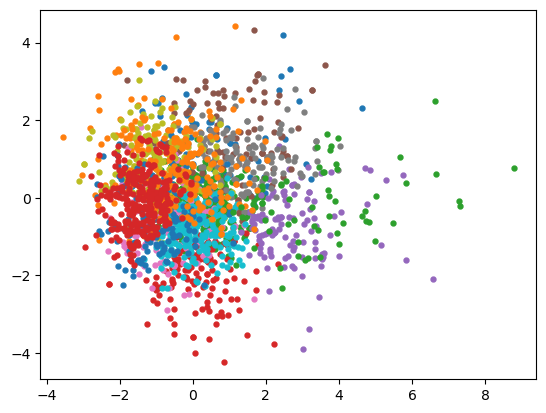

In [326]:
for c in np.unique(cluster_ids):
    plt.scatter(X_pca[cluster_ids == c, 0], X_pca[cluster_ids == c, 1], marker='.', s=50)

# PART II

In [ ]:
x = str(input("Please enter the name of a song you'd like to listen to: "))

In [327]:
#  For project clustering steps:
# 1- Load the Pandas data frame songs of the audio features (at least 1000 songs as different as possible).🎹 
# 2- Standardize the data using Standardscaler
# 3- Save the scaler for future use on the new user input song, using Pickle. (tomorrow)
# 4- Select the number of clusters k.
# 5- Adjust k means cluster.
# 6- Build the elbow graph to find the best k. (tomorrow)
# 7- Use the model with the best k to assign each observation in your data frame to its cluster number using model.predict (add cluster columns to the pandas data frame).
# 8- Save the model with the best k as your final model using pickle. (tomorrow)

# 📍 For the final product tasks and the full scenario:
# 1- Get the song name from the user as input ---------- DONE
# 2- Play the input song in the music embed player. ---------- DONE
# 3- Get the audio features for this song from the Spotify API using sp.audio_features(trackid). Be careful to keep only the audio features columns.---------- DONE
# 4- Load the StandardScaler using Pickle and use it to scale the REQUESTED_SONG.
# 5- Use kmeans_model.predict(new scaled audio dataset for the REQUESTED_SONG) to predict the cluster (label) for the REQUESTED_SONG.
# 6- Return a random song from the same cluster that the REQUESTED_SONG belongs to from your data frame and suggest it to the user.
# 7- Play it using the built-in music player.
# 8*- Try to Streamlit? ☀️ (optional) 